#  Uber vs Lyft Ultimate battle 
### Analyzing factors that contribute to Ridesharing prices & trips

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import networkx as nx
from netwulf import visualize
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [3]:
# load data from the kaggle website 
cab_rides = pd.read_csv("./cab_rides.csv",encoding = "utf-8")
weather = pd.read_csv("./weather.csv",encoding = "utf-8")

# Data clean

In [4]:
# data clean
cab_rides['date_time'] = pd.to_datetime(cab_rides['time_stamp']/1000, unit='s')
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit='s')
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999954
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050


In [5]:
# merge the datasets by same time and location
cab_rides['merge_date'] = cab_rides.source.astype(str) +" - "+ cab_rides.date_time.dt.date.astype("str") +" - "+ cab_rides.date_time.dt.hour.astype("str")
weather['merge_date'] = weather.location.astype(str) +" - "+ weather.date_time.dt.date.astype("str") +" - "+ weather.date_time.dt.hour.astype("str")

In [6]:
weather.index = weather['merge_date']
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105,Haymarket Square - 2018-12-16 - 9
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046,Haymarket Square - 2018-11-27 - 2
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999954,Haymarket Square - 2018-11-28 - 1
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072,Haymarket Square - 2018-11-30 - 4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050,Haymarket Square - 2018-11-29 - 3


In [8]:
merged_data = cab_rides.join(weather,on=['merge_date'],rsuffix ='_w')
merged_data['rain'].fillna(0,inplace=True)
merged_data = merged_data[pd.notnull(merged_data['date_time_w'])]
merged_data = merged_data[pd.notnull(merged_data['price'])]
merged_data['weekday'] = merged_data.date_time.dt.dayofweek
merged_data['hour'] = merged_data.date_time.dt.hour
merged_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w,merge_date_w,weekday,hour
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.29,1022.25,0.0000,1.544954e+09,0.76,7.68,2018-12-16 09:45:01,Haymarket Square - 2018-12-16 - 9,6,9
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1.00,1003.17,0.1123,1.543285e+09,0.90,13.69,2018-11-27 02:15:20,Haymarket Square - 2018-11-27 - 2,1,2
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.99,1002.59,0.0997,1.543287e+09,0.89,11.57,2018-11-27 02:45:20,Haymarket Square - 2018-11-27 - 2,1,2
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.00,1013.71,0.0000,1.543554e+09,0.70,5.25,2018-11-30 04:52:54,Haymarket Square - 2018-11-30 - 4,4,4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0.42,998.64,0.0000,1.543462e+09,0.71,11.30,2018-11-29 03:32:09,Haymarket Square - 2018-11-29 - 3,3,3


# Data Visualizations

In [10]:
countL=0
countU=0
CN = 0

Llist = [] # creating list w indexes for all Lyfts 
Ulist = [] # creating list w indexes for all Ubers
for line in merged_data['cab_type']:
    CN +=1 # cab number to index later
    if 'Lyft'in line:
        countL+=1
        Llist.append(CN-1)
    if 'Uber' in line:
        countU+=1
        Ulist.append(CN-1)
print("Total number of Ubers:", countU, len(Ulist)) 
print("Total number of Lyfts:", countL, len(Llist))
Llist[:10]


Total number of Ubers: 603878 603878
Total number of Lyfts: 561118 561118


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
print(len(merged_data['cab_type']))
print(len(merged_data['price']))
# creating lists of interesting variables to access later
hours = list(merged_data['hour'])
distances = list(merged_data['distance'])
prices = list(merged_data['price'])

1164996
1164996


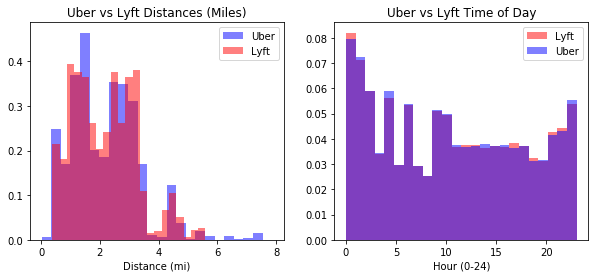

In [22]:
# lyft variables
Lhours = []
Ldistances = []
Lprices = []
for n in Llist:
    Lhours.append(hours[n])
    Ldistances.append(distances[n])
    Lprices.append(prices[n])

# uber variables
Uhours = []
Udistances = []
Uprices = []
for n in Ulist:
    Uhours.append(hours[n])
    Udistances.append(distances[n])
    Uprices.append(prices[n])
plt.figure(figsize=(10,4))

# plotting hours
plt.subplot(1,2,2)
import matplotlib.pyplot as plt
plt.hist(Lhours, alpha=0.5, bins=24,density=True, stacked = True, color='r', label = "Lyft")
plt.hist(Uhours, alpha=0.5, bins=24, density=True, stacked = True, color='b', label = "Uber")
plt.title("Uber vs Lyft Time of Day")
plt.xlabel("Hour (0-24)")
plt.legend()

# distances
plt.subplot(1,2,1)
plt.hist(Udistances, alpha=0.5, bins=24, density=True, stacked = True, color='b', label = "Uber")
plt.hist(Ldistances, alpha=0.5, bins=24, density=True, stacked = True, color='r', label = "Lyft")
plt.title("Uber vs Lyft Distances (Miles)")
plt.xlabel("Distance (mi)")
plt.legend()


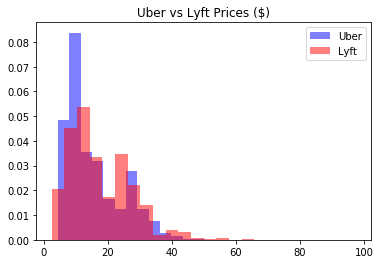

In [13]:
plt.hist(Uprices, alpha=0.5, bins=24, density=True, stacked = True, color='b', label = "Uber")
plt.hist(Lprices, alpha=0.5, bins=24, density=True, stacked = True, color='r', label = "Lyft")
plt.title("Uber vs Lyft Prices ($)")
plt.legend()
plt.show()

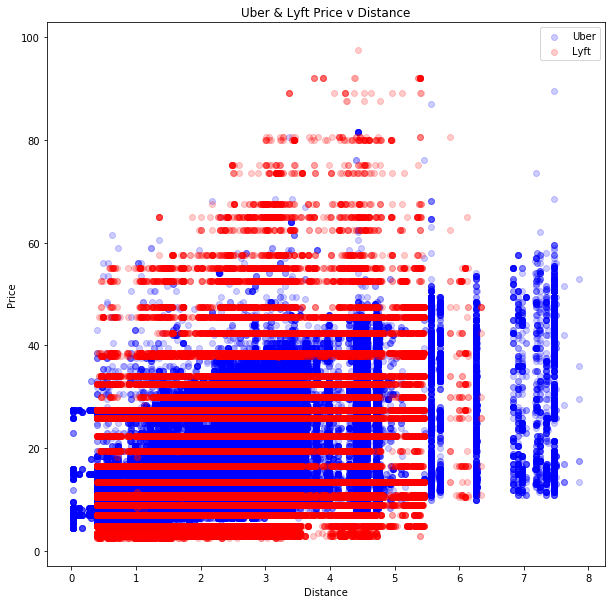

In [14]:
plt.figure(figsize=(10, 10)) # starting a figure  
plt.title('Uber & Lyft Price v Distance')
plt.scatter(Udistances, Uprices, alpha=0.2, color = 'b', label = "Uber")
plt.scatter(Ldistances, Lprices, alpha=0.2, color = 'r', label = "Lyft")
plt.xlabel('Distance')
plt.ylabel('Price')
plt.legend()

plt.show()

In [15]:
# Function that calculates the average price per mile of a given index list
def PricePerMile(indexlist):
    Idistances = []
    Iprices = []
    for n in indexlist:
        Idistances.append(distances[n])
        Iprices.append(prices[n])
    ppms = []
    for ride in range(len(indexlist)):
        price = Iprices[ride]
        distance = Idistances[ride]
        ppm = price/distance # calculating price per mile
        ppms.append(ppm)
    avgppm = sum(ppms)/len(ppms)
    return avgppm
print("Average Uber Price per Distance ($/mile)", PricePerMile(Ulist))
print("Average Lyft Price per Distance ($/mile)", PricePerMile(Llist))


Average Uber Price per Distance ($/mile) 9.722282744202905
Average Lyft Price per Distance ($/mile) 9.675428513999949


From this graph, it appears that for both cab services, the price increases as the distance does, as we would expect. Lyfts seem to generally be more expensive for shorter distances and do not seem to go as far. However, when I calculated the average price per mile, Lyfts were actually slightly less expensive. I noticed that from the histogram, we can see that the Uber dataset includes a few data points of rides with very small distances, which do not seem to overlap with Lyfts. In the next calculation, I exclude rides with a distance shorter than the shortest Lyft rides.

In [24]:
minLyftdist = min(Ldistances)
new_Ulist = [] # new list
c = 0
for ride in Ulist:
    distance = Udistances[c]
    if distance>=minLyftdist: # recalculating price to exclude those with shorter distances than in the Lyft dataset
        new_Ulist.append(ride)
    else: 
        pass
    c+=1
print("Average Uber Price per Distance ($/mile) (excluding short rides):", PricePerMile(new_Ulist))
print(new_Ulist[:10])

Average Uber Price per Distance ($/mile) (excluding short rides): 9.24716009021393
[24, 25, 26, 27, 28, 29, 40, 41, 42, 43]


The price per mile of Ubers goes down drastically after you exclude these short rides. Uber charges a base rate, so these rides all have a relatively high rate for their distances.

In [25]:
# looking at price for cab types
CN = 0
llist = [] # list of regular lyfts
ulist = [] # list of regular ubers (uberx)
countl = 0
countu = 0
for cab in merged_data['product_id']:
    CN +=1 # cab number to index later
    if cab == 'lyft': #regular lyfts
        countl+=1
        llist.append(CN-1)
    if cab == '55c66225-fbe7-4fd5-9072-eab1ece5e23e': #uber x
        countu+=1
        if distance>=minLyftdist:
            ulist.append(CN-1)
print("number of regular lyfts:", len(llist), "number of uberx's:", len(ulist))
print("Average price per mile for:")
print("UberX:", PricePerMile(ulist), "Regular Lyft:", PricePerMile(llist) )
# then do the same with other cab types

number of regular lyfts: 93886 number of uberx's: 100105
Average price per mile for:
UberX: 5.941140133780475 Regular Lyft: 5.380471250119266


# Data split

In [48]:
options = ['Lyft', 'UberX'] 
merged_data = merged_data[merged_data['name'].isin(options)] 

data_X = merged_data[['weekday','distance','hour','temp','clouds', 'pressure','humidity', 'wind', 'rain','name']]
data_y = merged_data['price'] 
data_y.count()

data_X.reset_index(inplace=True)
data_X = data_X.drop(columns=['index'])
data_X.head()

,weekday,distance,hour,temp,clouds,pressure,humidity,wind,rain,name
0,2,1.08,19,41.09,1.00,991.83,0.64,9.45,0.0,Lyft
1,2,1.08,19,40.51,1.00,992.59,0.66,9.88,0.0,Lyft
2,2,1.08,19,41.05,1.00,991.92,0.64,9.50,0.0,Lyft
3,3,1.11,19,32.75,0.51,1033.75,0.57,1.90,0.0,UberX
4,1,0.72,11,23.65,0.64,1006.82,0.54,16.19,0.0,Lyft


In [49]:
data_features = pd.get_dummies(data_X)
data_features.columns

Index(['weekday', 'distance', 'hour', 'temp', 'clouds', 'pressure', 'humidity',
       'wind', 'rain', 'name_Lyft', 'name_UberX'],
      dtype='object')

In [50]:
# Labels are the values we want to predict
labels = np.array(data_y)

# Saving feature names for later use
feature_list = list(data_features.columns)
# Convert to numpy array
data_features = np.array(data_features)

In [51]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_features, labels, test_size = 0.25, random_state = 50)

In [52]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (145493, 11)
Training Labels Shape: (145493,)
Testing Features Shape: (48498, 11)
Testing Labels Shape: (48498,)


# Decision Tree Regression

## Model

In [53]:
# Instantiate DecisionTree
regr_1 = DecisionTreeRegressor(max_depth=9,random_state=50,splitter="random")

# Train the model on training data
regr_1.fit(train_features, train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=50, splitter='random')

In [54]:
# Use the tree's predict method on the test data
prediction_TREE = regr_1.predict(test_features)

# Calculate the absolute errors
MAE_TREE = abs(prediction_TREE - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error of DisicionTree:', round(np.mean(MAE_TREE), 2), 'degrees.')

#linear regression 

Mean Absolute Error of DisicionTree: 0.97 degrees.


Too many branches and leaves we couldn't see which feature is the important, let's get the imoortances of features

## Important Features

In [55]:
# Get numerical feature importances
importance_TREE = list(regr_1.feature_importances_)
# List of tuples with variable and importance
feature_importance_TREE = [(data_features, round(importance_TREE, 2)) for data_features, importance_TREE in zip(feature_list, importance_TREE)]
# Sort the feature importances by most important first
feature_importance_TREE = sorted(feature_importance_TREE, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importance_TREE];

Feature: distance             Importance: 0.97
Feature: name_UberX           Importance: 0.01
Feature: weekday              Importance: 0.0
Feature: hour                 Importance: 0.0
Feature: temp                 Importance: 0.0
Feature: clouds               Importance: 0.0
Feature: pressure             Importance: 0.0
Feature: humidity             Importance: 0.0
Feature: wind                 Importance: 0.0
Feature: rain                 Importance: 0.0
Feature: name_Lyft            Importance: 0.0


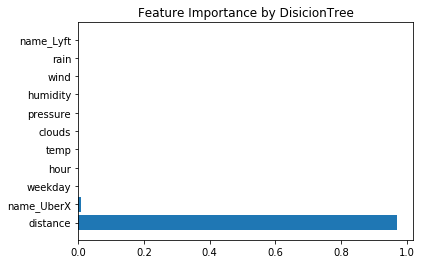

In [56]:
# plot feture importance
feature_importance_TREE_df = pd.DataFrame(feature_importance_TREE)
feature_importance_TREE_df[0]
plt.barh(range(len(feature_importance_TREE_df[0])), feature_importance_TREE_df[1],tick_label = feature_importance_TREE_df[0])
plt.title("Feature Importance by DisicionTree")
plt.show()

From tree's feature importances, only distance and cabtype-uber useful,we then try the random forest model

# Random Forest

## Model

In [57]:
# Instantiate model with 900 decision trees
rf = RandomForestRegressor(n_estimators = 900, random_state = 50)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=900,
                      n_jobs=None, oob_score=False, random_state=50, verbose=0,
                      warm_start=False)

In [58]:
# Use the forest's predict method on the test data
prediction_rf = rf.predict(test_features)

# Calculate the absolute errors
MAE_rf = abs(prediction_rf - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error of RandomForest:', round(np.mean(MAE_rf), 2), 'degrees.')

Mean Absolute Error of RandomForest: 0.93 degrees.


In [59]:
# Calculate mean absolute percentage error (MAPE)
MAPE_rf = 100 * (MAE_rf / test_labels)
# Calculate and display accuracy
accuracy_rf = 100 - np.mean(MAPE_rf)
print('Accuracy of RandomForest:', round(accuracy_rf, 2), '%.')

Accuracy of RandomForest: 90.92 %.


## Important Features

In [60]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importance_rf = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importance_rf = sorted(feature_importance_rf, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importance_rf];

Feature: distance             Importance: 0.7
Feature: temp                 Importance: 0.06
Feature: wind                 Importance: 0.06
Feature: pressure             Importance: 0.05
Feature: hour                 Importance: 0.03
Feature: clouds               Importance: 0.03
Feature: humidity             Importance: 0.03
Feature: weekday              Importance: 0.01
Feature: rain                 Importance: 0.01
Feature: name_Lyft            Importance: 0.01
Feature: name_UberX           Importance: 0.01


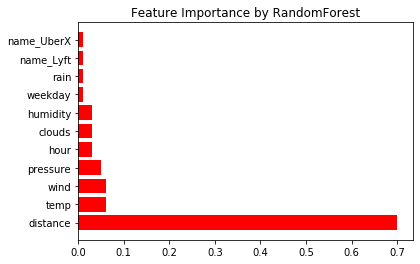

In [61]:
# plot feture importance randomforest
feature_importance_rf_df = pd.DataFrame(feature_importance_rf)
feature_importance_rf_df[0]
plt.barh(range(len(feature_importance_rf_df[0])), feature_importance_rf_df[1],tick_label = feature_importance_rf_df[0],fc = 'r')
plt.title("Feature Importance by RandomForest")
plt.show()

The feature importances of Randomforest shows that each frature is useful and the Ranking of features is

distance>temperture>pressure>wind>clouds>hour>humidity>rain>weekday

# Multiple Linear Regression

## Model

In [47]:
#create an instance of the model
lin_reg_mod = LinearRegression()

In [48]:
#fit the model on the training data:
lin_reg_mod.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
#make predictions on the testing set:
pred = lin_reg_mod.predict(test_features)

In [50]:
#We'll now check the predictions against the actual values by using the RMSE and R-2 metrics, two metrics commonly used to evaluate regression tasks:
test_set_rmse = (np.sqrt(mean_squared_error(test_labels, pred)))

test_set_r2 = r2_score(test_labels, pred)

In [51]:
#Let's print out the accuracy metrics and see what results we get:
print(test_set_rmse)
print(test_set_r2)

8.70356850749468
0.12577460223409154


In [52]:
print('Mean Absolute Error of Multiple Linear Regression:', round(np.mean(pred), 2), 'degrees.')

Mean Absolute Error of Multiple Linear Regression: 16.54 degrees.


Basically, the multiple regression model is not accurate for price predicting. 

# Map

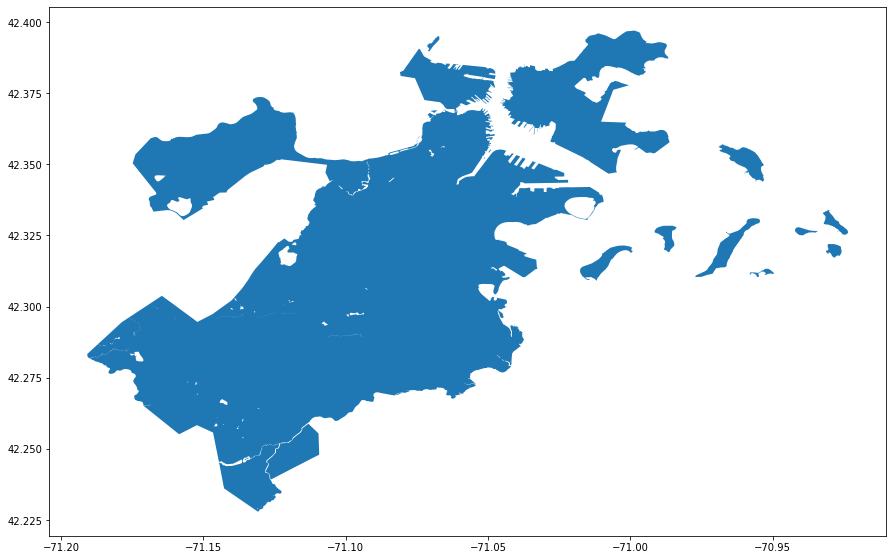

In [31]:
import pandas as pd 

#kaggle data of uber/lyft rides that include latitude/longitude
cab_file = './rideshare_kaggle.csv'
# Read data from file 'filename.csv' 
# (in the same directobry that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
cab2_data = pd.read_csv(cab_file) 

crs = {'init': 'epsg:4326'}

#upload map
street_map = gpd.read_file('./City_of_Boston_Boundary.shp')

#plot map
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax)

In [35]:
#take random sample of data because data set is too large 
sample1 = cab2_data.sample(frac=0.01, replace=False, random_state=1)

#convert ints to points
geometry = [Point(xy) for xy in zip(sample1['longitude'], sample1['latitude'])]

#add new column of points into data frame
geo_df = gpd.GeoDataFrame(sample1, crs = crs, geometry = geometry)

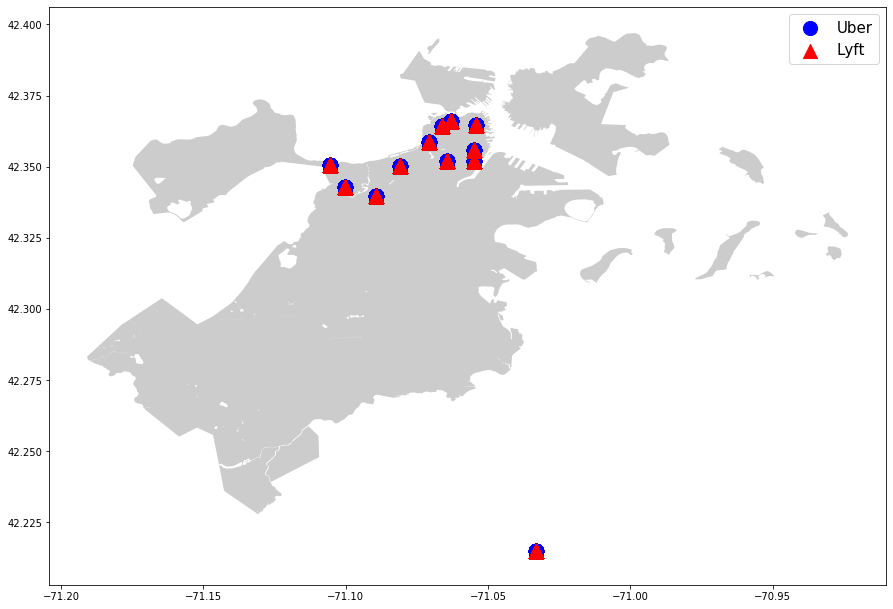

In [36]:
#plot points of long/lat onto map
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[sample1['cab_type']=='Uber'].plot(ax = ax, markersize = 200, color = "blue", marker = 'o', label = 'Uber')
geo_df[sample1['cab_type']=='Lyft'].plot(ax = ax, markersize = 200, color = "red", marker = '^', label = 'Lyft')
plt.legend(prop={'size':15})

# Network

In [38]:
#take sample of data because too large for network to handle
sample = merged_data.sample(frac=0.005, replace=False, random_state=1)

In [39]:
uber_ids = []
lyft_ids = []
ids = []

destinations = []
sources = []
destination_set = list(set(destinations))
sources_set = list(set(sources))

#split up uber and lyft ids and create lists for each
for line in sample['id']:
    ids.append(line)
    if sample['cab_type'] is 'Lyft':
        lyft_ids.append(line)
    else:
        uber_ids.append(line)

#create list of destinations same index as ids
for line in sample['destination']:
    destinations.append(line)

#create list of sources same index as ids
for line in sample['source']:
    sources.append(line)

In [44]:
car_network = nx.Graph()

#G.add_nodes_from(ids)
for id1 in uber_ids:
    ind = ids.index(id1)
    destination = destinations[ind]
    source = sources[ind]
    #add nodes with uber label
    car_network.add_node(id1, node_color = 'r')
    car_network.add_edge(id1, destination) 
    car_network.add_edge(id1, source) 

for id2 in lyft_ids:
    ind = ids.index(id2)
    destination = destinations[ind]
    source = sources[ind]
    #add nodes with lyft label
    car_network.add_node(id2, node_color = 'b')
    car_network.add_edge(id2, destination) 
    car_network.add_edge(id2, source) 

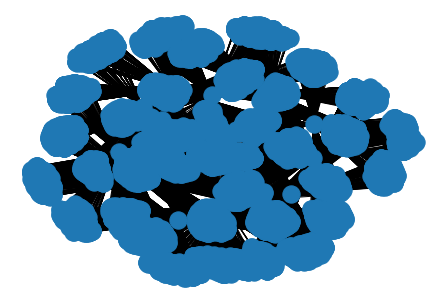

In [45]:
nx.draw(car_network, with_labels=False)

({'xlim': [0, 734],
  'ylim': [0, 734],
  'linkColor': '#0d38ea',
  'linkAlpha': 0.24607001995580982,
  'nodeStrokeColor': '#6014e8',
  'nodeStrokeWidth': 0.7908371839175632,
  'links': [{'source': 'acb7378a-88ec-4b89-9a2f-3c5a6a84a3f9',
    'target': 'Northeastern University',
    'width': 1.5816743678351264,
    'weight': 1},
   {'source': 'acb7378a-88ec-4b89-9a2f-3c5a6a84a3f9',
    'target': 'Beacon Hill',
    'width': 1.5816743678351264,
    'weight': 1},
   {'source': 'Northeastern University',
    'target': '1f6d97e2-4481-4a29-951b-570436f1cc1b',
    'width': 1.5816743678351264,
    'weight': 1},
   {'source': 'Northeastern University',
    'target': 'a381da89-fcd0-4362-ad51-b427c7b47c24',
    'width': 1.5816743678351264,
    'weight': 1},
   {'source': 'Northeastern University',
    'target': '8f4cfa5c-9c3b-4a1d-9706-b4fa56b0a478',
    'width': 1.5816743678351264,
    'weight': 1},
   {'source': 'Northeastern University',
    'target': '87c35e4f-1c74-461d-b03d-5da09a37dc65',
   

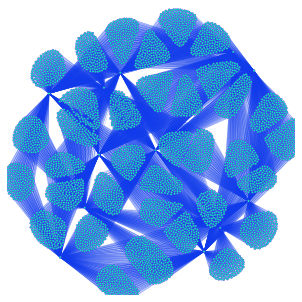

In [64]:
import networkx as nx
from netwulf import visualize

visualize(car_network)

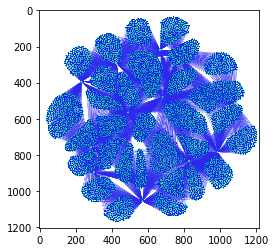

In [70]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('./network.png') 
  
# Output Images 
plt.imshow(img) 

# Calculate Average Price

In [63]:
# creating a function that takes a subset of the data and returns average price
def datasubset(variable, target, variable2, target2):
    indexes = []
    ppms = []
    i = 0
    for v1, v2 in zip(merged_data[variable], merged_data[variable2]):
        if v1 == target and v2 == target2:
            price = prices[i]
            distance = distances[i]
            indexes.append(i)
            ppm = price/distance
            ppms.append(ppm)
        i += 1
    avgppm = sum(ppms)/len(ppms)
    return(avgppm)
datasubset('source', 'North Station', 'destination', 'Haymarket Square')

10.033819656933497